In [1]:
!pip install YahooFinancials

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.9/51.9 kB 539.0 kB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for YahooFinancials: filename=yahoofinancials-1.20-py3-none-any.whl size=38617 sha256=ac4adfc5ca00d94d3f54f38836c050dacf7660ca4968e0e35ab02c8d89c94e46
  Stored in directory: /root/.cache/pip/wheels/cc/6b/dd/7ff776de4ebf7b144bb9562a813be59d0108306f368af9b637
Successfully built YahooFinancials


In [2]:
import pandas_datareader as pdr

In [3]:
import pandas as pd
import yfinance as yf
from yahoofinancials import YahooFinancials

df = yf.download('MDY', start='2012-01-01', end='2024-03-31', progress=False)
print(df.head())

                  Open        High         Low       Close   Adj Close  \
Date                                                                     
2012-01-03  163.089996  163.770004  160.770004  161.279999  138.518997   
2012-01-04  160.520004  161.500000  159.710007  160.839996  138.141098   
2012-01-05  160.050003  162.410004  158.449997  162.080002  139.206146   
2012-01-06  161.860001  163.009995  160.710007  161.929993  139.077286   
2012-01-09  162.699997  163.190002  161.339996  162.830002  139.850235   

             Volume  
Date                 
2012-01-03  3394900  
2012-01-04  1966100  
2012-01-05  2887300  
2012-01-06  2139500  
2012-01-09  1944400  


In [4]:
df.to_csv('MDY.csv')

In [5]:
df = pd.read_csv('MDY.csv')

In [6]:
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2012-01-03,163.089996,163.770004,160.770004,161.279999,138.518997,3394900
1,2012-01-04,160.520004,161.500000,159.710007,160.839996,138.141098,1966100
2,2012-01-05,160.050003,162.410004,158.449997,162.080002,139.206146,2887300
3,2012-01-06,161.860001,163.009995,160.710007,161.929993,139.077286,2139500
4,2012-01-09,162.699997,163.190002,161.339996,162.830002,139.850235,1944400


In [7]:
df.tail()

,Date,Open,High,Low,Close,Adj Close,Volume
3074,2024-03-22,550.229980,550.940002,545.250000,545.590027,545.590027,704100
3075,2024-03-25,546.299988,548.750000,545.770020,545.770020,545.770020,595700
3076,2024-03-26,547.590027,548.739990,544.809998,545.049988,545.049988,525300
3077,2024-03-27,548.049988,554.419983,547.869995,554.409973,554.409973,1131600
3078,2024-03-28,554.549988,558.340027,554.549988,556.400024,556.400024,1146200


In [8]:
df.shape

(3079, 7)

In [9]:
df1 = df.reset_index()['Close']

In [10]:
df1.shape

(3079,)

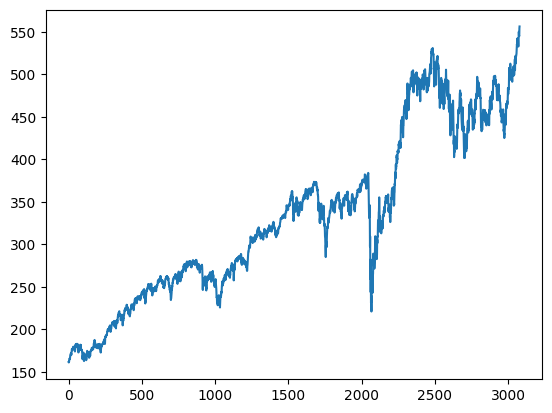

In [11]:
import matplotlib.pyplot as plt
plt.plot(df1)

In [12]:
import numpy as np

## Scaling Data Between 0 and 1

In [13]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler(feature_range=(0,1))
df1 = scaler.fit_transform(np.array(df1).reshape(-1,1))

In [14]:
df1

array([[0.00111235],
       [0.        ],
       [0.00313481],
       ...,
       [0.97130641],
       [0.99496903],
       [1.        ]])

## Splitting Data into Training and Test Set

In [15]:
training_size = int(len(df1) * 0.65)
test_size = len(df1) - training_size
train_data = df1[0 : training_size, :]
test_data = df1[training_size: len(df1), :1]

In [16]:
len(train_data), len(test_data)

(2001, 1078)

## Converting Array of Values into a Dataset Matrix

In [17]:
def create_dataset(dataset, time_step = 1):
  dataX = []
  dataY = []
  for i in range(len(dataset) - time_step - 1):
    a = dataset[i : (i+time_step),0]
    dataX.append(a)
    dataY.append(dataset[i+time_step,0])
  return np.array(dataX), np.array(dataY)

In [18]:
# Reshape into x = t, t+1, t+2, t+3 and y= t+4
time_step = 100
x_train, y_train = create_dataset(train_data, time_step)
x_test, y_test = create_dataset(test_data, time_step)

In [19]:
x_train.shape

(1900, 100)

# **Creating Stacked LSTM Model**

In [20]:
x_train = x_train.reshape(x_train.shape[0],x_train.shape[1],1)
x_test = x_test.reshape(x_test.shape[0],x_test.shape[1],1)

In [21]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM

In [22]:
model = Sequential()
model.add(LSTM(50, return_sequences = True, input_shape=(100,1)))
model.add(LSTM(50, return_sequences = True))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss = 'mean_squared_error', optimizer = 'adam')

In [23]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 100, 50)           10400     
                                                                 
 lstm_1 (LSTM)               (None, 100, 50)           20200     
                                                                 
 lstm_2 (LSTM)               (None, 50)                20200     
                                                                 
 dense (Dense)               (None, 1)                 51        
                                                                 
Total params: 50851 (198.64 KB)
Trainable params: 50851 (198.64 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [24]:
model.fit(x_train, y_train, validation_data = (x_test, y_test), epochs = 100, batch_size = 64, verbose = 1)

Epoch 1/100
30/30 [==============================] - 14s 284ms/step - loss: 0.0147 - val_loss: 0.0221
Epoch 2/100
30/30 [==============================] - 7s 235ms/step - loss: 9.2134e-04 - val_loss: 0.0016
Epoch 3/100
30/30 [==============================] - 6s 186ms/step - loss: 3.3762e-04 - val_loss: 0.0030
Epoch 4/100
30/30 [==============================] - 7s 225ms/step - loss: 3.1575e-04 - val_loss: 0.0028
Epoch 5/100
30/30 [==============================] - 5s 175ms/step - loss: 3.0813e-04 - val_loss: 0.0028
Epoch 6/100
30/30 [==============================] - 6s 214ms/step - loss: 3.1367e-04 - val_loss: 0.0029
Epoch 7/100
30/30 [==============================] - 6s 182ms/step - loss: 3.0160e-04 - val_loss: 0.0029
Epoch 8/100
30/30 [==============================] - 6s 216ms/step - loss: 3.0287e-04 - val_loss: 0.0032
Epoch 9/100
30/30 [==============================] - 6s 197ms/step - loss: 3.2173e-04 - val_loss: 0.0038
Epoch 10/100
30/30 [==============================] - 6s 1

# **Predicting and Checking Performance Matrix**

In [25]:
import tensorflow as tf
train_predict = model.predict(x_train)
test_predict = model.predict(x_test)

31/31 [==============================] - 1s 33ms/step


## Transform back to Original Form

In [26]:
train_predict = scaler.inverse_transform(train_predict)
test_predict = scaler.inverse_transform(test_predict)

## Calculating RMSE Performance Matrix

In [27]:
import math
from sklearn.metrics import mean_squared_error
math.sqrt(mean_squared_error(y_train, train_predict))
math.sqrt(mean_squared_error(y_test, test_predict))

452.54921685

# Plotting

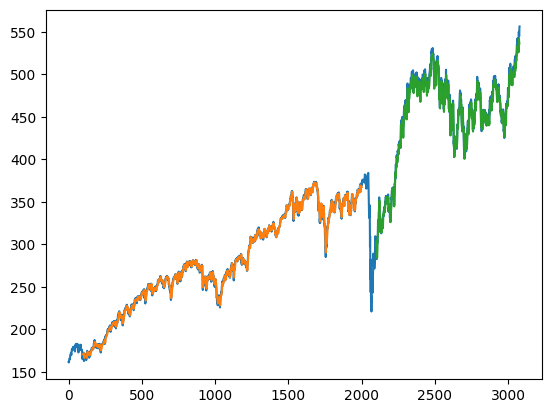

In [28]:
import matplotlib.pyplot as plt
%matplotlib inline
#Shift Train Prediction for Plotting
look_back = 100
trainPredictPlot = np.empty_like(df1)
trainPredictPlot[:,:] = np.nan
trainPredictPlot[look_back:len(train_predict) + look_back, : ] = train_predict

#Shift Test Prediction for Plotting
testPredictPlot = np.empty_like(df1)
testPredictPlot[:,:] = np.nan
testPredictPlot[len(train_predict) + (look_back*2)+1: len(df1)-1, : ] = test_predict

#Plotting Baseline and Prediction
plt.plot(scaler.inverse_transform(df1))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)

# **Predicting Future 30 Days**

In [29]:
len(test_data)

1078

In [30]:
x_input=test_data[978:].reshape(1,-1)
x_input.shape

(1, 100)

In [31]:
temp_input=list(x_input)
temp_input=temp_input[0].tolist()

In [32]:
temp_input

[0.7386237048488429,
 0.7272726571360835,
 0.7243907073688034,
 0.7190059244493263,
 0.7071240054650194,
 0.7208008263723824,
 0.7190312297504551,
 0.762994175691774,
 0.7681767476531456,
 0.755662813343084,
 0.7657245251032059,
 0.7710081639684763,
 0.7651430432294009,
 0.7719688396076723,
 0.7772524784729424,
 0.7752047549895227,
 0.7676457992312897,
 0.7720952118126998,
 0.77861757602835,
 0.8073363925487926,
 0.8167913171339805,
 0.8010415445923769,
 0.7986398554943865,
 0.8053898131195798,
 0.8107745188887487,
 0.8170946721462933,
 0.8151480927170804,
 0.845864022118685,
 0.8758720974414569,
 0.8588835223991649,
 0.8603751464602165,
 0.8770855946410161,
 0.8565072157526117,
 0.8740771955184004,
 0.8788804965640724,
 0.8885124039565455,
 0.8892707914873277,
 0.8885124039565455,
 0.8760743855498707,
 0.8719283279807735,
 0.8430831392553035,
 0.8406056885545434,
 0.8450550239856451,
 0.8614621943044403,
 0.8526139797438779,
 0.8564312998492252,
 0.8529678682081401,
 0.852588674442749

In [33]:
from numpy import array

lst_output=[]
n_steps=100
i=0
while(i<30):

    if(len(temp_input)>100):
        #print(temp_input)
        x_input=np.array(temp_input[1:])
        print("{} day input {}".format(i,x_input))
        x_input=x_input.reshape(1,-1)
        x_input = x_input.reshape((1, n_steps, 1))
        #print(x_input)
        yhat = model.predict(x_input, verbose=0)
        print("{} day output {}".format(i,yhat))
        temp_input.extend(yhat[0].tolist())
        temp_input=temp_input[1:]
        #print(temp_input)
        lst_output.extend(yhat.tolist())
        i=i+1
    else:
        x_input = x_input.reshape((1, n_steps,1))
        yhat = model.predict(x_input, verbose=0)
        print(yhat[0])
        temp_input.extend(yhat[0].tolist())
        print(len(temp_input))
        lst_output.extend(yhat.tolist())
        i=i+1


print(lst_output)

[0.9781359]
101
1 day input [0.72727266 0.72439071 0.71900592 0.70712401 0.72080083 0.71903123
 0.76299418 0.76817675 0.75566281 0.76572453 0.77100816 0.76514304
 0.77196884 0.77725248 0.77520475 0.7676458  0.77209521 0.77861758
 0.80733639 0.81679132 0.80104154 0.79863986 0.80538981 0.81077452
 0.81709467 0.81514809 0.84586402 0.8758721  0.85888352 0.86037515
 0.87708559 0.85650722 0.8740772  0.8788805  0.8885124  0.88927079
 0.8885124  0.87607439 0.87192833 0.84308314 0.84060569 0.84505502
 0.86146219 0.85261398 0.8564313  0.85296787 0.85258867 0.84437248
 0.83554957 0.84540899 0.85789762 0.87261095 0.8672767  0.859465
 0.86750422 0.86874302 0.88077654 0.87733842 0.85377687 0.87119525
 0.87008289 0.85554654 0.86156334 0.8688694  0.88044788 0.89005448
 0.90231567 0.87003228 0.88800676 0.91182121 0.89920621 0.88952369
 0.89278483 0.91242792 0.91202334 0.91159362 0.91707947 0.91786316
 0.928203   0.93732926 0.94718876 0.94344728 0.95219427 0.96437955
 0.95702296 0.9512336  0.95803409 0.

In [34]:
day_new=np.arange(1,101)
day_pred=np.arange(101,131)

In [35]:
len(df1)

3079

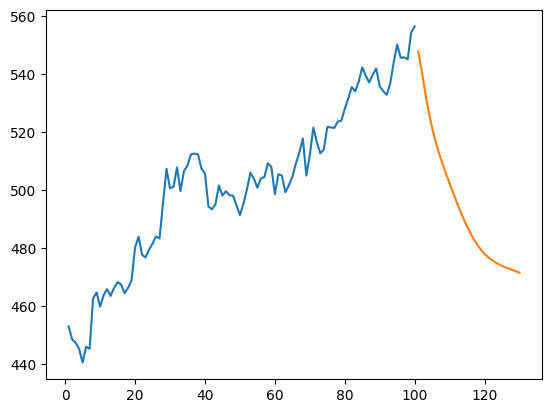

In [36]:
plt.plot(day_new,scaler.inverse_transform(df1[2979:]))
plt.plot(day_pred,scaler.inverse_transform(lst_output))

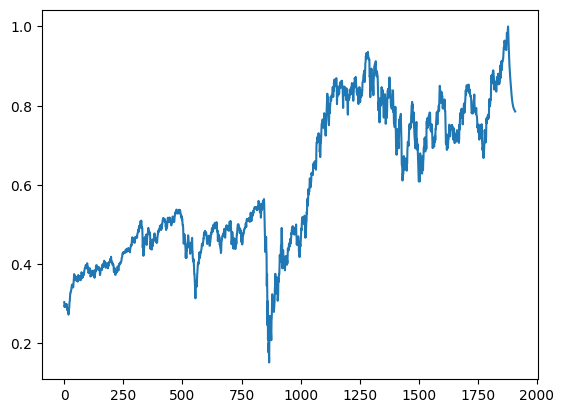

In [37]:
df3=df1.tolist()
df3.extend(lst_output)
plt.plot(df3[1200:])

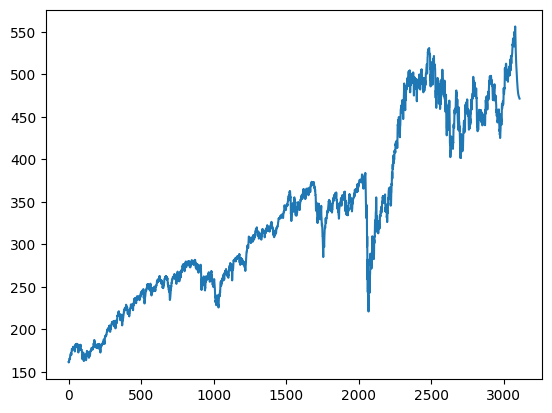

In [38]:
df3=scaler.inverse_transform(df3).tolist()
plt.plot(df3)